# Model Training and Evaluation 

## Predicting MLB game results

This notebook explores the training and evaluation of machine learning models on the outcomes of MLB games using a dataset composed of current season statistics.

### Notebook Setup

Import the necessary dependencies.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from utils.notebook_setup import setup_notebook_env, load_env_variables

Setup the notebook environment. Add the project root to `sys.path` so higher-level modules can be accessed from this notebook, and load environment variables that are required to configure connection to the PostgreSQL database.

In [2]:
setup_notebook_env()
load_env_variables()

Now, import the remaining dependencies that couldn't be accessed prior to the notebook environment setup, and connect to the database.

In [3]:
from shared.database import connect_to_db
from machine_learning.data.processing.mlb_data_pipeline import MLBDataPipeline

session = connect_to_db()

### Model Selection

Read the relevant database tables into DataFrames so training data can be prepared using the data pipeline class.

In [4]:
teams_df = pd.read_sql_table("mlb_teams", session.bind)
schedule_df = pd.read_sql_table("mlb_schedule", session.bind)
offensive_stats_df = pd.read_sql_table("mlb_offensive_stats", session.bind)
defensive_stats_df = pd.read_sql_table("mlb_defensive_stats", session.bind)

Prepare training data for a given date range.

In [5]:
data_pipeline = MLBDataPipeline(rolling_window=10, head_to_head_window=5)

start_date = datetime(2024, 3, 20)
end_date = datetime(2024, 10, 30)

training_data = data_pipeline.prepare_training_data(
    schedule_df=schedule_df,
    teams_df=teams_df,
    offensive_stats_df=offensive_stats_df,
    defensive_stats_df=defensive_stats_df,
    start_date=start_date,
    end_date=end_date
)

Inspect the training data for missing values or any other inconsistencies.

In [6]:
pd.set_option('display.max_columns', None)
training_data.tail()

,home_rolling_win_pct,away_rolling_win_pct,home_rolling_runs_scored,away_rolling_runs_scored,home_rolling_runs_allowed,away_rolling_runs_allowed,home_days_rest,away_days_rest,home_batting_avg,away_batting_avg,home_obp,away_obp,home_slg,away_slg,home_era,away_era,home_whip,away_whip,home_strikeouts,away_strikeouts,h2h_home_win_pct,h2h_away_win_pct,h2h_games_played,month,day_of_week,is_weekend,game_id,game_date,home_team_id,away_team_id,home_team_won,run_differential
2550,0.7,0.6,6.1,4.4,3.7,4.7,1.0,1.0,0.258,0.263,0.335,0.324,0.446,0.420,3.90,3.86,1.23,1.22,1390,1453,0.6,0.4,5,10,4,0,775317,2024-10-11,119,135,True,2.0
2551,0.4,0.6,3.4,3.1,3.0,3.2,1.0,1.0,0.238,0.234,0.307,0.300,0.395,0.385,3.61,3.61,1.20,1.16,1410,1354,0.6,0.4,5,10,5,1,775326,2024-10-12,114,116,True,4.0
2552,0.8,0.6,6.1,4.7,3.3,3.7,2.0,1.0,0.258,0.246,0.335,0.319,0.446,0.415,3.90,3.96,1.23,1.26,1390,1455,0.8,0.2,5,10,6,1,775307,2024-10-13,119,121,True,9.0
2553,0.8,0.6,6.6,4.3,3.0,3.8,2.0,4.0,0.258,0.246,0.335,0.319,0.446,0.415,3.90,3.96,1.23,1.26,1390,1455,1.0,0.0,5,10,0,0,775306,2024-10-14,119,121,False,-4.0
2554,0.5,0.5,4.6,3.6,4.4,2.7,1.0,2.0,0.248,0.238,0.333,0.307,0.429,0.395,3.74,3.61,1.24,1.20,1457,1410,0.6,0.4,5,10,0,0,775314,2024-10-14,147,114,True,3.0


Create an instance of the `TimeSeriesSplit` Time Series cross-validator, and drop any irrelevant columns from the training data. Define and instantiate the models to be evaluated, and create the empty `results` object to be used to store the performance metrics for each model.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

timestamp_cols = training_data.select_dtypes(include=["datetime64"]).columns

feature_cols = [col for col in training_data.columns if col not in ["home_team_won", "run_differential"] + list(timestamp_cols)]

models = {
    "random_forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "logistic_regression": LogisticRegression(max_iter=10000, random_state=42),
    "svc": SVC(random_state=42)
}

results = {}

Fit and train each model, using the Time Series cross-validator to split the data into training and test splits. Impute missing values in the training data, since NaN values are not accepted by the `LinearRegression` model. Then, make predictions and evaluate the results of each model for each fold of the training data, storing the results in a dictionary.

In [8]:
imputer = SimpleImputer(strategy='mean')

for name, model in models.items():
    fold_scores = []
    for train_index, test_index in tscv.split(training_data):
        X_train, X_test = training_data.iloc[train_index][feature_cols], training_data.iloc[test_index][feature_cols]
        y_train, y_test = training_data.iloc[train_index]["home_team_won"], training_data.iloc[test_index]["home_team_won"]

        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        scores = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        }
        fold_scores.append(scores)
        
    results[name] = fold_scores

/Users/josephbarkie/Coding/betbot/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josephbarkie/Coding/betbot/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Inspect the average results of each model.

In [9]:
for model_name, scores in results.items():
    df = pd.DataFrame(scores)
    print(f"\n{model_name} mean results:")
    print(df.mean())


random_forest mean results:
accuracy     0.538353
precision    0.566571
recall       0.557551
f1           0.558053
dtype: float64

logistic_regression mean results:
accuracy     0.543059
precision    0.563774
recall       0.699003
f1           0.610889
dtype: float64

svc mean results:
accuracy     0.507294
precision    0.417882
recall       0.800000
f1           0.548830
dtype: float64


### Hyperparameter Tuning 

Implement hyperparameter tuning using `GridSearchCV` with time series cross-validation in an effort to improve model performance. First, handle missing values in the training data, since most `sklearn` models can't handle NaN values directly. This will be accomplished in preprocessing pipelines for each model, in which NaN values are filled with a mean and the features are scaled. Update the existing `models` dictionary to include these preprocessing steps.

In [10]:
print("Columns with NaN values:")
print(training_data[feature_cols].isna().sum()[training_data[feature_cols].isna().sum() > 0])

preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())  
])

models = {
    "random_forest": Pipeline([
        ('preprocessing', preprocessing),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    "logistic_regression": Pipeline([
        ('preprocessing', preprocessing),
        ('model', LogisticRegression(random_state=42))
    ]),
    "svc": Pipeline([
        ('preprocessing', preprocessing),
        ('model', SVC(random_state=42))
    ])
}

Columns with NaN values:
home_rolling_win_pct         139
away_rolling_win_pct         129
home_rolling_runs_scored     139
away_rolling_runs_scored     129
home_rolling_runs_allowed    139
away_rolling_runs_allowed    129
home_days_rest                16
away_days_rest                18
dtype: int64


Define parameter grids for each model and initialize dictionaries to store the results.

In [11]:
param_grids = {
    "random_forest": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },
    "logistic_regression": {
        "model__C": [0.1, 1, 10, 100],
        "model__penalty": ["l1", "l2"],
        "model__solver": ["liblinear", "saga"]
    },
    "svc": {
        "model__C": [0.1, 1, 10, 100],
        "model__kernel": ["linear", "poly", "rbf"],
        "model__gamma": ["scale", "auto"]
    }
}

best_models = {}
results = {}

Next, create a `GridSearchCV` object with the appropriate time series split and fit the grid search. Store the best model and collect the results.

In [12]:
for name, model in models.items():
        print(f"\nTuning {name}...")

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            cv=tscv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(training_data[feature_cols], training_data["home_team_won"])
        
        best_models[name] = grid_search.best_estimator_
        
        fold_scores = []
        for train_index, test_index in tscv.split(training_data):
            X_train = training_data.iloc[train_index][feature_cols]
            X_test = training_data.iloc[test_index][feature_cols]
            y_train = training_data.iloc[train_index]["home_team_won"]
            y_test = training_data.iloc[test_index]["home_team_won"]
            
            best_models[name].fit(X_train, y_train)
            y_pred = best_models[name].predict(X_test)
            
            scores = {
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred)
            }
            fold_scores.append(scores)
        
        results[name] = fold_scores
        
        print(f"Best parameters for {name}:")
        print(grid_search.best_params_)
        print(f"Best cross-validation score: {grid_search.best_score_:.3f}")


Tuning random_forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for random_forest:
{'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best cross-validation score: 0.553

Tuning logistic_regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for logistic_regression:
{'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best cross-validation score: 0.570

Tuning svc...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for svc:
{'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best cross-validation score: 0.560


Evaluate the average performance of each model.

In [13]:
print("\nTuned Model Performance:")
for model_name, scores in results.items():
    df = pd.DataFrame(scores)
    print(f"\n{model_name}:")
    print(df.mean())


Tuned Model Performance:

random_forest:
accuracy     0.553412
precision    0.580463
recall       0.601108
f1           0.581753
dtype: float64

logistic_regression:
accuracy     0.570353
precision    0.590755
recall       0.666564
f1           0.614288
dtype: float64

svc:
accuracy     0.560471
precision    0.575481
recall       0.693552
f1           0.617996
dtype: float64


Visualize the results in a bar chart.

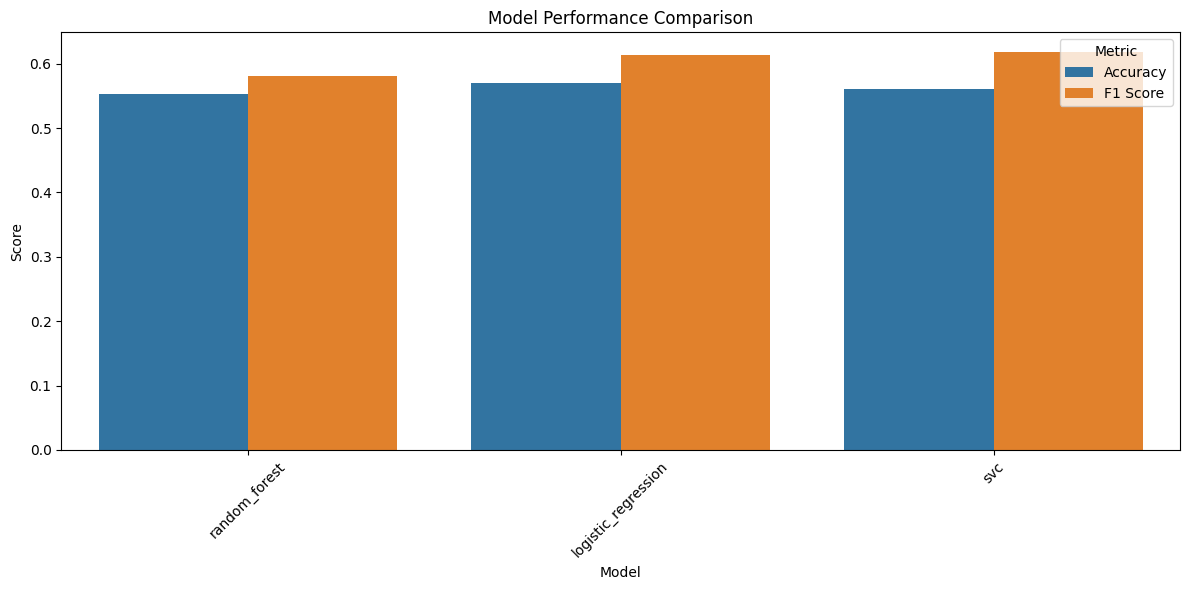

In [14]:
plt.figure(figsize=(12, 6))
metrics_df = pd.DataFrame([
    {
        'Model': model_name,
        'Accuracy': pd.DataFrame(scores).accuracy.mean(),
        'F1 Score': pd.DataFrame(scores).f1.mean()
    }
    for model_name, scores in results.items()
])

metrics_df_melted = pd.melt(metrics_df, id_vars=['Model'], var_name='Metric', value_name='Score')
sns.barplot(data=metrics_df_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()